In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it
from sklearn.preprocessing import StandardScaler
import warnings

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from pyearth import Earth

In [2]:
train = pd.read_csv('data/train.csv')
train.shape

(5380, 767)

In [3]:
test = pd.read_csv('data/test.csv')
test.shape

(4403, 766)

## Missing Values

In [4]:
num_missing = train.isna().sum().sum()
print(num_missing)

num_cols_missing = (train.isna().any()).sum()
print(num_cols_missing)

num_rows_missing = (train.isna().any(axis=1)).sum()
print(num_rows_missing)

29911
473
2523


In [5]:
imputer = KNNImputer(n_neighbors = 5)

In [6]:
train = pd.DataFrame(imputer.fit_transform(train), columns = train.columns)
test = pd.DataFrame(imputer.fit_transform(test), columns = test.columns)

## Feature Selection

In [7]:
train = train.fillna(0)
y_train = train['y']
X_train = train.drop(['y', 'id'], axis = 1)

In [8]:
corr = abs(X_train.corrwith(y_train))
corr[corr.isnull()==True]

x063   NaN
x137   NaN
x255   NaN
x385   NaN
x405   NaN
x453   NaN
x465   NaN
x518   NaN
x594   NaN
x643   NaN
x703   NaN
dtype: float64

In [9]:
X_train = X_train.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)
X_test = test.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)

In [10]:
corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_columns = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
X_train = X_train.drop(corr_columns, axis=1)
X_test = X_test.drop(corr_columns, axis=1)

<ipython-input-10-329baf4ed854>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [11]:
X_train.shape

(5380, 151)

## PCA

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

col_id = X_test['id']
X_test = X_test.drop(['id'], axis = 1)
X_test = scaler.transform(X_test)

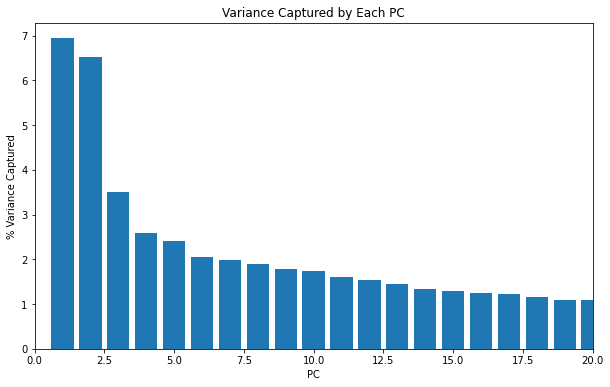

In [57]:
pca_all = PCA()
pca_all.fit(X_train)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca_all.explained_variance_ratio_) + 1), pca_all.explained_variance_ratio_ * 100)
plt.xlabel('PC')
plt.xlim([0,20])
plt.ylabel('% Variance Captured')
plt.title('Variance Captured by Each PC')
plt.show()

In [13]:
pca = PCA(n_components=3)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_train.shape

(5380, 3)

In [14]:
X_test = pca.transform(X_test)
X_test.shape

(4403, 3)

## AdaBoost

>3 12.397 (0.334)
>4 12.180 (0.405)
>5 12.226 (0.450)
>6 12.261 (0.453)
>7 12.290 (0.395)
>8 12.406 (0.346)
>9 12.591 (0.612)
>10 13.105 (0.579)
>11 13.395 (0.283)
>12 13.473 (0.367)
>13 13.475 (0.368)
>14 13.648 (0.559)


Text(0.5, 0, 'Number of trees')

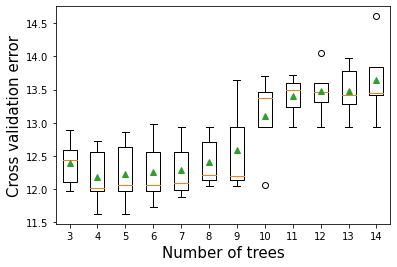

In [15]:
def get_models():
    models = dict()
    for n in range(3, 15):
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 12.675 (0.863)
>2 12.335 (0.974)
>3 14.438 (2.856)
>4 19.460 (2.830)
>5 20.191 (1.403)
>6 18.459 (0.941)
>7 15.203 (0.563)
>8 13.419 (0.963)
>9 12.393 (1.259)
>10 11.894 (1.352)


Text(0.5, 0, 'Depth of each tree')

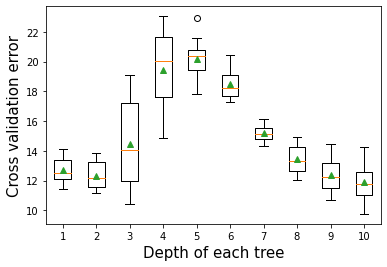

In [16]:
def get_models():
    models = dict()
    for i in range(1,11):
        base = DecisionTreeRegressor(max_depth=i)
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

In [17]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [4]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=2), DecisionTreeRegressor(max_depth=3)]

cv = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: -148.509763 using {'base_estimator': DecisionTreeRegressor(max_depth=3), 'n_estimators': 4}


In [18]:
model_ADA = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), n_estimators=4,
                              random_state=1).fit(X_train, y_train)

## RF

In [19]:
warnings.filterwarnings("ignore")

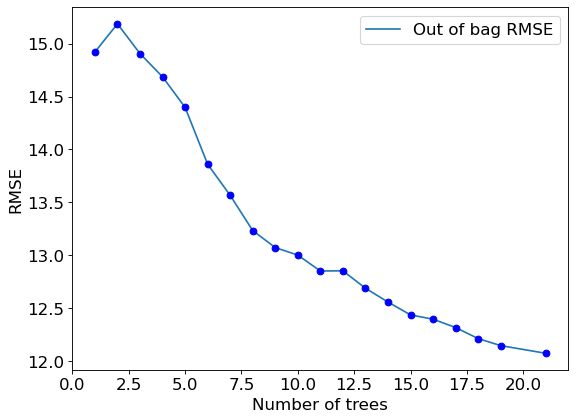

In [20]:
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}
for i in np.linspace(1, 21, 20,dtype=int):
    model = RandomForestRegressor(n_estimators=i, random_state=1,max_features="sqrt",
                        n_jobs=-1,oob_score=True).fit(X_train, y_train)
    oob_rsquared[i]=model.oob_score_  
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y_train))
    
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

Text(0, 0.5, 'Classification accuracy')

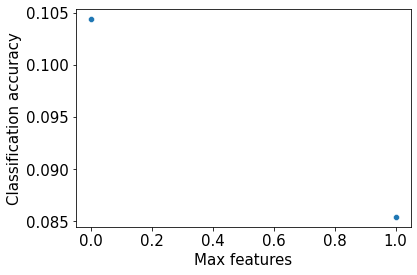

In [22]:
oob_score = {}

i=0
for pr in range(1, 3):
    model = RandomForestRegressor(random_state=1, oob_score=True, verbose=False, n_estimators = 500,
                                  max_features=pr, n_jobs=-1).fit(X_train, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
sns.scatterplot(x = oob_score.keys(), y = oob_score.values())
plt.xlabel('Max features')
plt.ylabel('Classification accuracy')

In [23]:
params = {'n_estimators': [6],
          'max_features': [1,2,3]}
param_list=list(it.product(*(params[Name] for Name in params)))
oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_features=pr[1],n_jobs=-1).fit(X_train, y_train)
    oob_score[i] = model.oob_score_
    i=i+1
    
print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (6, 1)
Best score (R-squared) =  -0.330774283306402


In [24]:
model_RF = RandomForestRegressor(n_estimators=6, max_features=1, random_state=1, n_jobs=-1).fit(X_train, y_train)

## XGBoost

>3 11.543 (0.784)
>4 11.364 (0.743)
>5 11.270 (0.684)
>6 11.244 (0.635)
>7 11.270 (0.611)
>8 11.268 (0.563)
>9 11.270 (0.529)
>10 11.318 (0.488)


Text(0.5, 0, 'Number of trees')

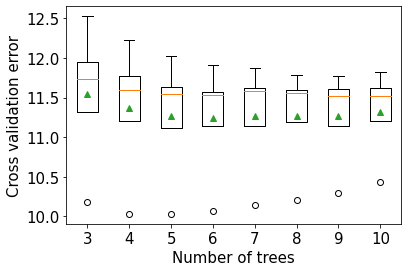

In [25]:
def get_models():
    models = dict()
    for n in range(3, 11):
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 10.877 (1.349)
>2 11.115 (1.385)
>3 11.341 (1.378)
>4 11.695 (1.477)
>5 11.859 (1.325)
>6 11.899 (1.401)


Text(0.5, 0, 'Depth of each tree')

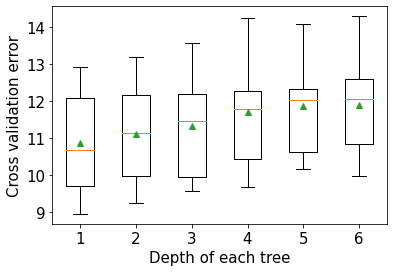

In [26]:
def get_models():
    models = dict()
    for i in range(1, 7):
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0100 11.5 (1.7)
>0.0150 11.3 (1.6)
>0.0200 11.2 (1.6)
>0.0250 11.2 (1.5)
>0.0300 11.2 (1.5)


Text(0.5, 0, 'Learning rate')

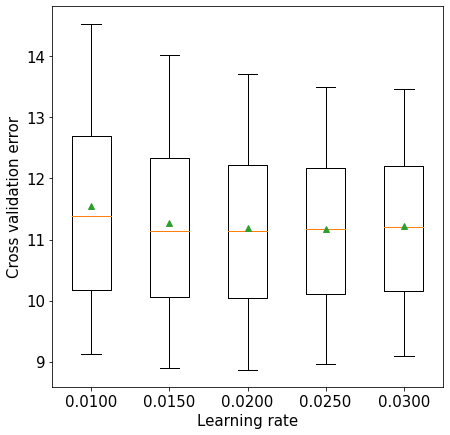

In [27]:
def get_models():
    models = dict()
    for i in [0.010, 0.015, 0.020, 0.025, 0.030]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
    
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0100 12.2 (1.4)
>0.0500 12.2 (1.3)
>0.1000 12.3 (1.4)
>0.2500 12.1 (1.4)
>0.5000 12.0 (1.4)
>1.0000 11.9 (1.4)


Text(0.5, 0, 'reg_lambda')

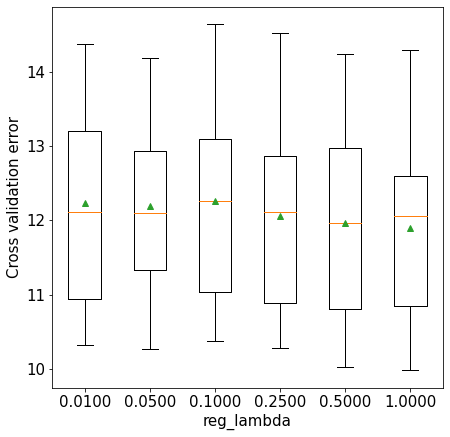

In [28]:
def get_models():
    models = dict()
    for i in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))

plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

In [29]:
param_grid = {'n_estimators':[4, 5],
              'max_depth': [2, 3, 4],
              'learning_rate': [0.100, 0.125, 0.150],
              'reg_lambda':[0.15, 0.20, 0.25]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train , y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Optimal parameter values = {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 5, 'reg_lambda': 0.2}
Optimal cross validation R-squared =  0.040702634097943655


In [30]:
model_XG = xgb.XGBRegressor(random_state=1, max_depth=2, n_estimators=5, learning_rate = 0.15, reg_lambda=0.2).fit(X_train, y_train)

## Ensemble

In [31]:
model_ensemble= StackingRegressor(estimators = [('ADA', model_ADA),
                                                ('RF', model_RF),
                                                ('XG', model_XG)],
                      final_estimator = LassoCV(),
                      cv = KFold(n_splits = 5, shuffle = True, random_state=1))
model_ensemble.fit(X_train, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                  estimators=[('ADA',
                               AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                                                 n_estimators=4,
                                                 random_state=1)),
                              ('RF',
                               RandomForestRegressor(max_features=1,
                                                     n_estimators=6, n_jobs=-1,
                                                     random_state=1)),
                              ('XG',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_byl...
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constrain

In [32]:
model_ensemble.final_estimator_.coef_

array([0.02539829, 0.01824538, 1.66137181])

In [33]:
pred14 = model_ensemble.predict(X_test)

pred_v14 = pd.DataFrame(index=range(X_test.shape[0]), columns=range(2))
pred_v14.columns = ['id', 'y']
pred_v14['id'] = col_id
pred_v14['y'] = pred14
pred_v14

,id,y
0,5380.0,7.480825
1,5381.0,9.481876
2,5382.0,5.884710
3,5383.0,5.875588
4,5384.0,6.255718
...,...,...
4398,9778.0,5.918160
4399,9779.0,5.972565
4400,9780.0,9.475794
4401,9781.0,9.709471


In [34]:
pred_v14.to_csv('pred_v14.csv', index=True)